In [52]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from os import walk
import matplotlib.pyplot as plt
%matplotlib inline 

/Users/samuelcroker/Applications/anaconda/envs/Python3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/samuelcroker/Applications/anaconda/envs/Python3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
#import os
#os.system("scp FILE USER@SERVER:PATH")

In [33]:
maccsv = '/Users/samuelcroker/Documents/repositories/Router-tools/mac-names.csv'
macdf = pd.read_csv(maccsv, names = ['mac','devicename'],quotechar="'")

In [34]:
dailypath = '/Users/samuelcroker/Documents/routerdata/'
dailyfiles = []
for (dirpath, dirnames, filenames) in walk(dailypath):
    dailyfiles.extend(filenames)
    break

In [86]:
idx = 0
for f in dailyfiles:
    #print(idx)
    if f[-3:] == 'dat':
        df = pd.read_csv(dailypath+f, names = ['Device','PostIN KB','PostOut KB','PreIn KB','PreOut KB','LastSeen'])
        df['dtstamp'] = np.repeat(dt.date(int(f[6:10]),int(f[10:12]),int(f[12:14])),len(df))
        df['idx'] = idx
        if idx == 0:
            finaldf = df.copy()                 
        else:
            finaldf = pd.concat([finaldf,df])
        idx += 1
finaldf['totalGB'] = (finaldf['PostIN KB'] + finaldf['PostOut KB'])/1e6

#join with devicenames
finaldf = finaldf.merge(macdf, left_on='Device', right_on='mac', how='inner')

devicetotal = finaldf.groupby(['Device','devicename'])['totalGB'].sum()
dailytotal = finaldf.groupby(['dtstamp'])['totalGB'].sum()

# make the devicenames "other" when the gb is < 1
finaldf.loc[finaldf['totalGB'] < 1, 'devicename'] = 'Other'
devicedaily = finaldf.groupby(['dtstamp','devicename'])['totalGB'].sum()

In [87]:
devicedaily

dtstamp     devicename          
2016-12-21   'Apple TV'             24.772498
             'Joyes iPad'            3.193191
             'PS4 ETH'               4.800753
             'SAS Laptop L7A517'     1.004008
             'Samuels iPhone'        1.725519
            Other                    1.368596
2016-12-22   'Apple TV'             10.490668
             'Samuels MacBook'       1.468312
             'iMac'                  1.722550
            Other                    3.123354
2016-12-23   'Apple TV'              4.652904
             'iMac'                  1.045312
            Other                    3.216386
2016-12-24  Other                    0.519881
2016-12-25  Other                    0.236053
2016-12-26  Other                    0.002020
2016-12-27  Other                    0.004189
2016-12-28  Other                    0.001366
2016-12-29  Other                    0.001470
2016-12-30  Other                    0.001824
2016-12-31  Other                    0.003664
2

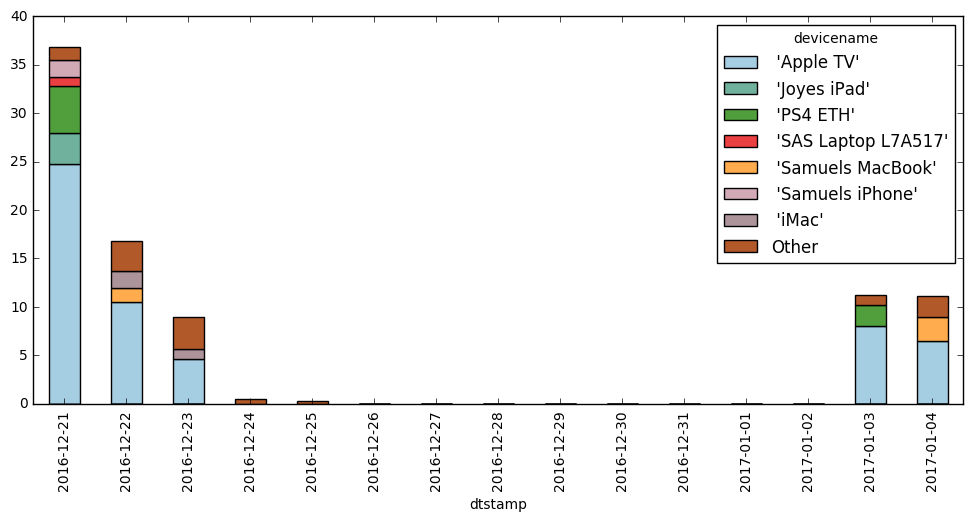

In [97]:

df2 = devicedaily.unstack('devicename').fillna(0)
df2.plot(kind='bar',stacked=True, colormap='Paired',figsize=(12, 5))


In [77]:
df2


dtstamp,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,2017-01-01,2017-01-02,2017-01-03,2017-01-04
devicename,,,,,,,,,,,,,,,
'Amelias Kindle',0.243393,0.028029,0.044808,0.041071,0.234295,0.000514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099873,0.019688
'Apple TV',24.772498,10.490668,4.652904,0.001067,0.001340,0.001299,0.004017,0.001178,0.001274,0.001496,0.003480,0.001560,0.001097,8.003254,6.492261
'Apple Watch',0.000016,0.000057,0.000163,0.000062,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000030
'HP60721D',0.000018,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000
'Joyes iPad',3.193191,0.080069,0.608495,0.007994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.196030,0.193639
'Joyes iPhone',0.221870,0.619681,0.058092,0.031169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.179453,0.081094
'PS4 ETH',4.800753,0.880692,0.685403,0.000055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.175942,0.844575
'Patricks Kindle',0.238495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256799,0.052522
'SAS Laptop L7A517',1.004008,0.407220,0.000000,0.031813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114322
